<a href="https://colab.research.google.com/github/psylanrex/notebooks/blob/master/fv_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, log, exp
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot

In [0]:
warnings.filterwarnings('ignore')

# Data Prep and Cleaning

In [10]:
house_price_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Zillow Single Family Residence.csv')
house_price_df.head(3)

,Unnamed: 0,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,...,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
0,0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,...,924400,935600,947200,950900,952700,959000,966400,970300,973200,973300,970600,971800,977800,985200,992900,997600,996000,993100,991500,990000,991400,998200,1004000,1006800,1008400,1011300,1015500,1022000,1028900,1034500,1037400,1038700,1041500,1042800,1042900,1044400,1047800,1049700,1048300,1047900
1,1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,...,318600,321800,324400,326400,327400,326900,327300,328900,330000,330000,328900,327500,326300,325300,324700,324700,323700,322100,320800,320400,320300,320900,320900,320300,319800,320200,320800,321100,322700,326500,330400,332700,334500,335900,337000,338300,338400,336900,336000,336500
2,2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,...,1199200,1206600,1218000,1226400,1230300,1234700,1240300,1244700,1245800,1245300,1243700,1243400,1245000,1250800,1259300,1266600,1270800,1274500,1278900,1282600,1285800,1288100,1288500,1287500,1289200,1295000,1301100,1304300,1310100,1315300,1317900,1321100,1325300,1323800,1321200,1320700,1319500,1318800,1319700,1323300


In [11]:
house_price_df.rename(columns={'RegionName': 'ZipCode', 'CountyName': 'County'}, inplace=True)
house_price_df['County'] = house_price_df['County'].str.replace(' County', '')
house_price_df.head(3)

,Unnamed: 0,RegionID,ZipCode,City,State,Metro,County,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,...,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
0,0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,...,924400,935600,947200,950900,952700,959000,966400,970300,973200,973300,970600,971800,977800,985200,992900,997600,996000,993100,991500,990000,991400,998200,1004000,1006800,1008400,1011300,1015500,1022000,1028900,1034500,1037400,1038700,1041500,1042800,1042900,1044400,1047800,1049700,1048300,1047900
1,1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris,2,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,...,318600,321800,324400,326400,327400,326900,327300,328900,330000,330000,328900,327500,326300,325300,324700,324700,323700,322100,320800,320400,320300,320900,320900,320300,319800,320200,320800,321100,322700,326500,330400,332700,334500,335900,337000,338300,338400,336900,336000,336500
2,2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook,3,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,...,1199200,1206600,1218000,1226400,1230300,1234700,1240300,1244700,1245800,1245300,1243700,1243400,1245000,1250800,1259300,1266600,1270800,1274500,1278900,1282600,1285800,1288100,1288500,1287500,1289200,1295000,1301100,1304300,1310100,1315300,1317900,1321100,1325300,1323800,1321200,1320700,1319500,1318800,1319700,1323300


In [12]:
house_price_processed_df = house_price_df.drop(['Metro', 'SizeRank', 'Unnamed: 0'], axis=1)
house_price_processed_df.head(3)

,RegionID,ZipCode,City,State,County,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,...,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
0,84654,60657,Chicago,IL,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,...,924400,935600,947200,950900,952700,959000,966400,970300,973200,973300,970600,971800,977800,985200,992900,997600,996000,993100,991500,990000,991400,998200,1004000,1006800,1008400,1011300,1015500,1022000,1028900,1034500,1037400,1038700,1041500,1042800,1042900,1044400,1047800,1049700,1048300,1047900
1,91982,77494,Katy,TX,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,268000.0,277000.0,283600.0,...,318600,321800,324400,326400,327400,326900,327300,328900,330000,330000,328900,327500,326300,325300,324700,324700,323700,322100,320800,320400,320300,320900,320900,320300,319800,320200,320800,321100,322700,326500,330400,332700,334500,335900,337000,338300,338400,336900,336000,336500
2,84616,60614,Chicago,IL,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,610100.0,618600.0,625600.0,...,1199200,1206600,1218000,1226400,1230300,1234700,1240300,1244700,1245800,1245300,1243700,1243400,1245000,1250800,1259300,1266600,1270800,1274500,1278900,1282600,1285800,1288100,1288500,1287500,1289200,1295000,1301100,1304300,1310100,1315300,1317900,1321100,1325300,1323800,1321200,1320700,1319500,1318800,1319700,1323300


In [13]:
house_price_processed_df.dropna(axis=0, inplace=True)
house_price_processed_df.shape

(14338, 278)

In [14]:
fv = house_price_processed_df[house_price_processed_df['City'] == 'Fountain Valley'].copy()
fv.drop(columns=['RegionID', 'ZipCode', 'City', 'State', 'County'], inplace=True)
fv = fv.T
fv.reset_index(inplace=True)
fv.rename(columns={'index': 'Time', 864: 'Price'}, inplace=True)
fv['Time'] = pd.to_datetime(fv['Time'])
fv.set_index(keys=['Time'], inplace=True)
fv.head()

,Price
Time,
1996-04-01,219900.0
1996-05-01,220000.0
1996-06-01,220300.0
1996-07-01,220500.0
1996-08-01,220700.0


In [0]:
fv_series = pd.Series(fv['Price'])
fv_series.index = fv.index

In [35]:
fv_series.head(10)

Time
1996-04-01    219900.0
1996-05-01    220000.0
1996-06-01    220300.0
1996-07-01    220500.0
1996-08-01    220700.0
1996-09-01    221100.0
1996-10-01    221600.0
1996-11-01    222100.0
1996-12-01    222900.0
1997-01-01    223900.0
Name: Price, dtype: float64

In [20]:
split_point = len(fv_series) - 12
dataset, validation = fv_series[0:split_point], fv_series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 261, Validation 12


# Modeling Prep

In [0]:
scores = {}

## Performance Baseline

In [0]:
series = pd.read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

In [0]:
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.5)
train,test = X[0:train_size], X[train_size:]

In [25]:
# walk-forward validation
history = [x for x in X]
predictions = list()
for i in range(len(test)):
  # predict
  yhat = history[-1]
  predictions.append(yhat)
  history.append(test[i])
  # print('Predicted = %.3f, Expected = %.3f' % (yhat, test[i]))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE = %.3f' % rmse)

RMSE = 7489.769


In [0]:
scores['baseline'] = rmse

# Data Analysis

In [28]:
series.describe()

count       261.000000
mean     531076.628352
std      174353.718359
min      219900.000000
25%      363100.000000
50%      576200.000000
75%      673200.000000
max      785900.000000
Name: 1, dtype: float64

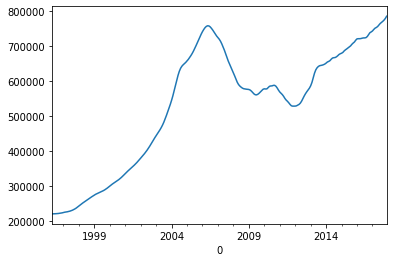

In [29]:
series.plot()
plt.show()

- There's an increasing trend over the years
- The spike and dip in the middle may seem to interupt the trend but the overall trend is increasing

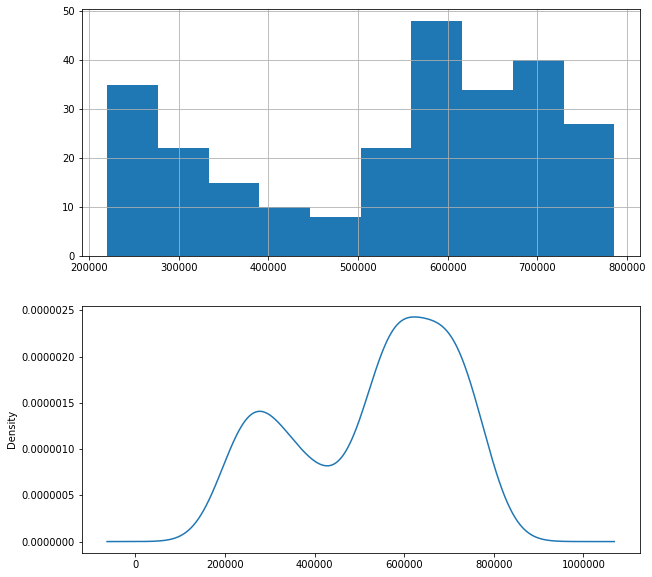

In [30]:
plt.figure(figsize=(10,10))
plt.subplot(211)
series.hist(ax=plt.gca())
plt.subplot(212)
series.plot(kind='kde', ax=plt.gca())
plt.show()

- The distribution is not Gaussian
- The distribution is right shifted
- It may be worth exploring power transforming of the data prior to modeling

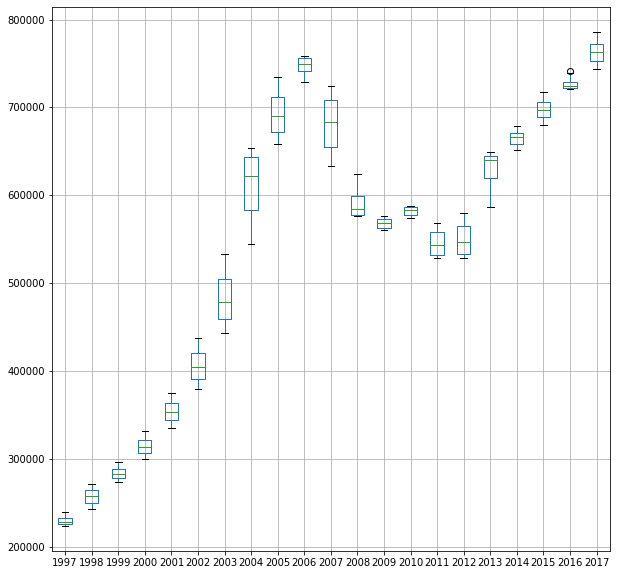

In [37]:
plt.figure(figsize=(10,10))
groups = series['1997':'2017'].groupby(pd.Grouper(freq='Y'))
years = pd.DataFrame()
for name, group in groups:
  years[name.year] = group.values
years.boxplot()
plt.show()

- The median of the years 2004 to 2007 seem to be above the over trend.
- Those years also have wider spread for the middle 50% of the data

9


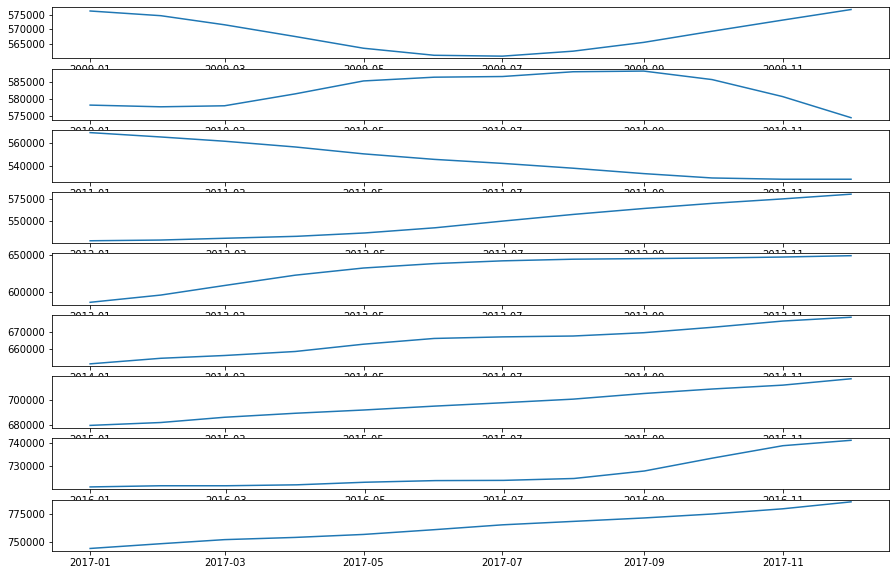

In [51]:
years = pd.DataFrame()
plt.figure(figsize=(15,10))
i = 1
groups = series['2009':'2017'].groupby(pd.Grouper(freq='Y'))
n_groups = len(groups)
print(n_groups)
for name, group in groups:
  plt.subplot((n_groups * 100) + 10 + i)
  i += 1
  plt.plot(group)
plt.show()

# ARIMA Models

## Transformation and Staionarity Check

In [0]:
def check_stationarity(data):
  result = adfuller(data)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Value:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

### Differencing

In [0]:
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i-interval]
    diff.append(value)
  return pd.Series(diff)

ADF Statistic: -2.232388
p-value: 0.194701
Critical Value:
	1%: -3.458
	5%: -2.874
	10%: -2.573


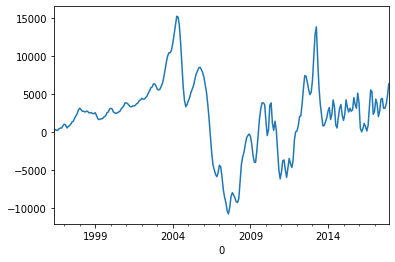

In [67]:
diff_1 = difference(X)
diff_1.index = series.index[1:]
# check for stationarity
check_stationarity(diff_1)
# plot difference data
diff_1.plot()
plt.show()

ADF Statistic: -2.013799
p-value: 0.280556
Critical Value:
	1%: -3.459
	5%: -2.874
	10%: -2.573


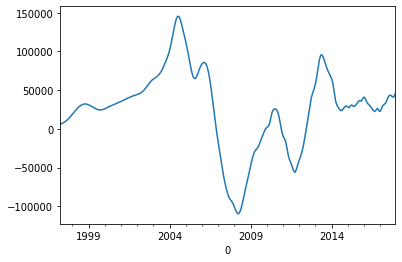

In [66]:
diff_12 = difference(X, interval=12)
diff_12.index = series.index[12:]
check_stationarity(diff_12)

diff_12.plot()
plt.show()

- Differencing might not be enough to achieve stationary

### Log Scale

ADF Statistic: -1.951850
p-value: 0.308076
Critical Value:
	1%: -3.457
	5%: -2.873
	10%: -2.573


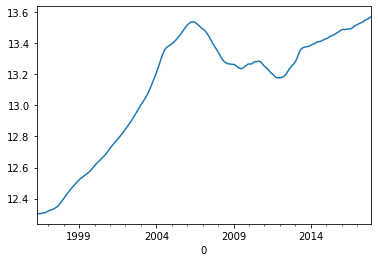

In [77]:
log_scale = np.log(X)
check_stationarity(log_scale)

log_scale = pd.Series(log_scale)
log_scale.index = series.index
log_scale.plot()
plt.show()

- Log scale doesn't help achieve stationarity

### Box-Cox

Lambda: 1.534066


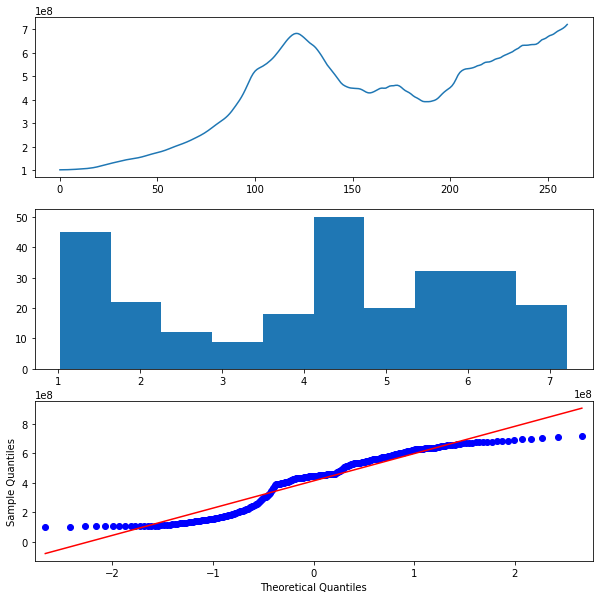

In [113]:
boxcox_transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
plt.figure(figsize=(10, 10))
plt.subplot(311)
plt.plot(boxcox_transformed)
plt.subplot(312)
plt.hist(boxcox_transformed)
plt.subplot(313)
qqplot(boxcox_transformed, line='r', ax=plt.gca())
plt.show()

In [114]:
check_stationarity(boxcox_transformed)

ADF Statistic: -1.038920
p-value: 0.738806
Critical Value:
	1%: -3.457
	5%: -2.873
	10%: -2.573


- Boxcox transformation doesn't achieve stationarity

### Seasonal Decomposition

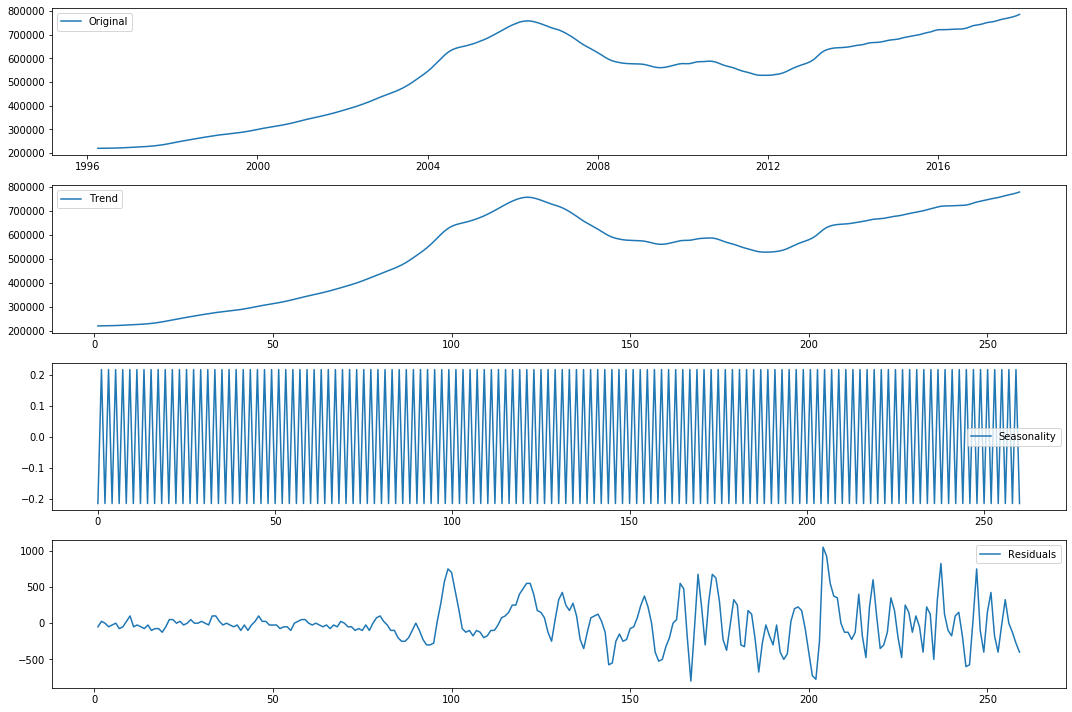

In [96]:
# decomp_freq = int(24*60/15*30)
decomposition = seasonal_decompose(X, freq=2)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15,10))

plt.subplot(411)
plt.plot(series, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [108]:
decomp_resid = pd.Series(residual)
decomp_resid.fillna(0, inplace=True)
decomp_resid.index = series.index
check_stationarity(decomp_resid)

ADF Statistic: -4.646094
p-value: 0.000106
Critical Value:
	1%: -3.457
	5%: -2.873
	10%: -2.573


- Decomposition can help the time series achieve stationarity

In [100]:
print('X[1] = ', X[1])
print('resid[1] = ', residual[1])
print('trend[1] = ', trend[1])
print('seasonal[1] = ', seasonal[1])

X[1] =  220000.0
resid[1] =  -50.21615980918307
trend[1] =  220050.0
seasonal[1] =  0.21615980918306565


In [118]:
print('original', X[0:9])
print('trend', trend[0:9])
print('seasonal', seasonal[0:9])
print('resid', residual[0:9])

original [219900. 220000. 220300. 220500. 220700. 221100. 221600. 222100. 222900.]
trend [    nan 220050. 220275. 220500. 220750. 221125. 221600. 222175. 222950.]
seasonal [-0.21615981  0.21615981 -0.21615981  0.21615981 -0.21615981  0.21615981
 -0.21615981  0.21615981 -0.21615981]
resid [  0.         -50.21615981  25.21615981  -0.21615981 -49.78384019
 -25.21615981   0.21615981 -75.21615981 -49.78384019]


In [0]:
def inverse_decompose(decomp_item, yhat):
  return yhat + decomp_item.trend + decomp_item.seasonal

## Manually Configured ARIMA Hyperparameters

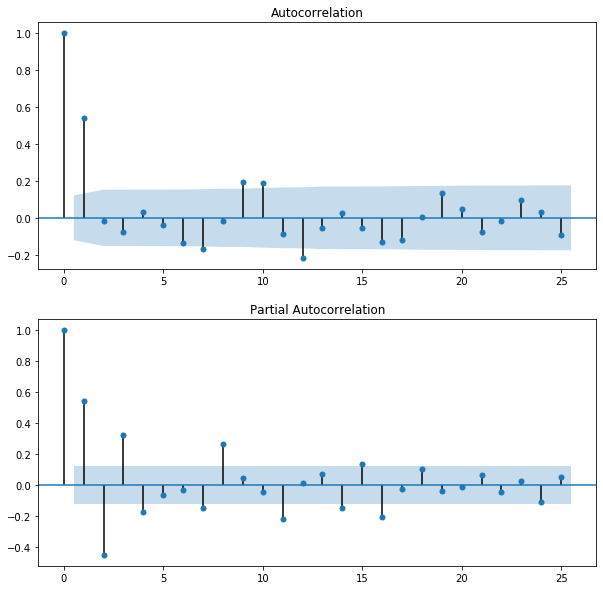

In [110]:
transformed = decomp_resid
plt.figure(figsize=(10,10))
plt.subplot(211)
plot_acf(transformed, lags=25, ax=plt.gca())
plt.subplot(212)
plot_pacf(transformed, lags=25, ax=plt.gca())
plt.show()

- ACF shows significant lag at 9 or 10
- PACF shows significant lag at 1
- Try p = 9 and q = 1

In [0]:
def seasonal_decompose_transform(data, i):
  decomp = seasonal_decompose(data)
  trend = decomp.trend
  seasonal = decomp.seasonal
  residual = decomp.resid
  return [trend[i], seasonal[i], residual[i]]

In [0]:
# walk-forward validation
history = [x for x in X]
predictions = list()
transformed_test = seasonal_decompose(test)
for i in range(len(test)):
  # transform
  decomposed_history = seasonal_decompose(history)
  decomposed_history_resid = decomposed_history.resid
  # predict
  model = ARIMA(decomposed_history_resid, order=(1,0,1))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  yhat = yhat + 